# **Group_5 Assignment** - Bike Sharing

# 📝 Group Assignment: Abstract and Introduction

## Abstract

This project focuses on a deep data analysis of the Washington D.C. bike-sharing service (2011–2012) to derive actionable insights for **operational efficiency** and **service improvement**. Our primary goal is to develop a predictive model for **hourly bike demand ($cnt$)** to optimize bike provisioning and reduce the costs associated with outsourcing transportation.

Exploratory Data Analysis (EDA) reveals two distinct customer segments—**Registered (commuters)** with strong daily (24-hour) periodicity and **Casual (leisure)** users exhibiting more seasonal, weather-dependent demand. The time-series analysis confirms these patterns (strong positive correlation at lags **1–3**, **24**, and **48**), necessitating a modeling strategy that accounts for strong **lag features** and **segment-specific behavior** to achieve the target **95% service availability** while maintaining a high **bike utilization rate (60–80%)**.

***

## Introduction

The modern bike-sharing system relies heavily on balancing two opposing forces: **service availability** and **operational efficiency**. Failure to meet demand results in lost revenue and dissatisfied customers, while oversupply leads to unnecessary maintenance and redistribution costs.

This analysis utilizes hourly usage data, alongside temporal and meteorological features, to address this trade-off. Our methodology begins with a robust **Exploratory Data Analysis (EDA)** to dissect usage patterns across hours, days, and seasons. The time-series nature of the data, highlighted by strong autocorrelation peaks at lag **24 hours** (daily cycle) and **48 hours**, confirms the need for advanced forecasting techniques.

### Key Objectives:

1.  **Understand Citizen Usage:** Quantify the different demand profiles of Registered and Casual users to tailor service offerings and relocation strategies.
2.  **Optimize Logistics:** Use demand patterns (e.g., strong commute peaks) to suggest targeted rebalancing efforts, minimizing reliance on costly outsourced transportation.
3.  **Predictive Modeling:** Build a robust regression model (e.g., using **Gradient Boosting**) to forecast $cnt$ hourly. Crucially, the model will leverage the finding that **modeling $casual$ and $registered$ segments separately** and summing the results will yield higher accuracy due to their fundamentally different time-series behaviors.

This data-driven approach will help management move from reactive rebalancing to **proactive provisioning**, directly supporting the KPI goal of maintaining $\geq 95\%$ availability.

## PART I: Exploratory Data Analysis

In [2]:
!pip install antropy
!pip install statsmodels
!pip install scikit-optimize
!pip install shap


In [3]:
import pandas as pd
import numpy as np
from antropy import spectral_entropy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib, datetime, json
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import shap
from pathlib import Path
from plotly.subplots import make_subplots
import os
from pathlib import Path

c:\Users\Radwan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Ensuring Dataset Integrity

Before starting the analysis, we verify that the dataset loads correctly, all expected columns are present, and there are no missing values or inconsistent data types.
This helps ensure that any patterns we find later come from real behavior, not from data quality issues.

In [4]:
import os
from pathlib import Path
NOTEBOOK_DIR = Path(os.getcwd())
display(NOTEBOOK_DIR)
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_PATH = PROJECT_ROOT / "data" / "bike-sharing-hourly.csv"
ARTS_PATH = PROJECT_ROOT / "artifacts"
ARTS_PATH.mkdir(exist_ok=True, parents=True)
print(f"Project Root: {PROJECT_ROOT}")

WindowsPath('c:/Users/Radwan/Downloads/IE University/Term_2/PYTHON FOR DATA ANALYSIS II/Group Assignment/PYGroupAssigF')

Project Root: c:\Users\Radwan\Downloads\IE University\Term_2\PYTHON FOR DATA ANALYSIS II\Group Assignment


In [5]:
# import pandas as pd
# from pathlib import Path

# # Define the precise, fixed path
# DATA_PATH = Path(r"C:\Users\Radwan\Downloads\IE University\Term_2\PYTHON FOR DATA ANALYSIS II\Group Assignment\bike-sharing\data\bike-sharing-hourly.csv")

try:
    # Load the data and ensure the 'dteday' column is parsed as a datetime object
    df = pd.read_csv("bike-sharing-hourly.csv", parse_dates=['dteday'])
    print("✅ Data successfully loaded!")
    
    # You can now proceed with your diagnostic prints:
    print("=====================================\n df.head()")
    display(df.head())
    print("=====================================\n df.info()")
    df.info() # Changed to df.info() for cleaner output in notebooks
    
except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: File not found at the specified path: {DATA_PATH}")

✅ Data successfully loaded!
 df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


 df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt        

##### Utility Functions for Consistent Plots

To keep all charts looking the same and avoid repeating code, we define a few helper functions.

* set_fig_layout() gives every chart the same font, color theme, and centered title.

* set_fig_and_show() quickly draws a line plot with labels and then applies the same layout.

* plot_hist_distribution() shows a histogram and boxplot together, marking the quartiles (Q1 and Q3) and the limits that define possible outliers using the IQR method.

In [6]:
# utils/helpers

def set_fig_layout(figure):
        figure.update_layout(
        template='plotly_white', title_x=0.5,
        font=dict(family='Times New Roman', size=16),
        title_font=dict(size=24), legend_title_text='User Type'
        )
        figure.show()
        

def set_fig_and_show(dataframe:pd.DataFrame,
                     x:pd.DataFrame.index,
                     y: list, plot_title:str,
                     x_label:str,y_label:str,
                     lagend:str):
    
    figure = px.line(dataframe,x = x,
                 y= y,
                 markers= True,
                 title=f"<b>{plot_title}<b>",
                 labels={'x': x_label, 'value': y_label, 'variable': lagend}
                 )
    set_fig_layout(figure)
    figure.write_html( f"{plot_title}.html")


def plot_hist_distribution(df, target_col,iqr_upper_limit,iqr_lower_limit,color):
    # Calculate quartiles and IQR
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_lower_limit * IQR
    upper_bound = Q3 + iqr_upper_limit * IQR

    # Create the histogram with boxplot
    fig_hist = px.histogram(
        df,
        x=target_col,
        nbins=50,
        marginal="box",
        title=f"Distribution of {target_col.capitalize()} (IQR = {IQR:.2f})",
        color_discrete_sequence=[color]
    )

    # Add vertical lines for Q1, Q3, and bounds
    fig_hist.add_vline(x=Q1, line_dash="dash", line_color="orange", annotation_text="Q1")
    fig_hist.add_vline(x=Q3, line_dash="dash", line_color="green", annotation_text="Q3")
    fig_hist.add_vline(x=lower_bound, line_dash="dot", line_color="red", annotation_text="Lower Bound")
    fig_hist.add_vline(x=upper_bound, line_dash="dot", line_color="red", annotation_text="Upper Bound")

    set_fig_layout(fig_hist)
    fig_hist.write_html( f"Distribution of {target_col.capitalize()} (IQR = {IQR:.2f}).html" )

# def add_features(x: pd.DataFrame) -> pd.DataFrame:
#         # EQ bases
#     def temp_curve(temp, b0=0.0, b1=25.0, b2=-0.5):
#         temp = np.asarray(temp)
#         return b0 + b1*temp + b2*temp**2

#     def humidity_quad(hum, b0=0.0, b1=15.0, b2=-0.15):
#         hum = np.asarray(hum)
#         return b0 + b1*hum + b2*hum**2

#     def humidity_exp(hum, a=300.0, c=50.0, k=0.025):
#         hum = np.asarray(hum)
#         return c + a*np.exp(-k*hum)

#     def wind_curve(wind, b0=150.0, b1=6.0, b2=-0.15):
#         wind = np.asarray(wind)
#         return b0 + b1*wind + b2*wind**2

#     def bimodal_hour(hr,
#                     A1=280.0, mu1=8.0,  sigma1=1.4,
#                     A2=420.0, mu2=17.5, sigma2=1.8,
#                     c=30.0):
#         hr = np.asarray(hr)
#         g1 = A1*np.exp(-(hr - mu1)**2/(2*sigma1**2))
#         g2 = A2*np.exp(-(hr - mu2)**2/(2*sigma2**2))
#         return g1 + g2 + c

#     def workingday_hour(hr, workday,
#                         A1_w=260, mu1_w=8.0,  s1_w=1.3,
#                         A2_w=480, mu2_w=17.5, s2_w=1.7, c_w=20,
#                         A1_we=120, mu1_we=11.0, s1_we=2.2,
#                         A2_we=260, mu2_we=18.5, s2_we=2.0, c_we=30):
#         hr = np.asarray(hr)
#         workday = np.asarray(workday).astype(int)
#         y_w  = (A1_w*np.exp(-(hr-mu1_w)**2/(2*s1_w**2))
#             +A2_w*np.exp(-(hr-mu2_w)**2/(2*s2_w**2)) + c_w)
#         y_we = (A1_we*np.exp(-(hr-mu1_we)**2/(2*s1_we**2))
#             +A2_we*np.exp(-(hr-mu2_we)**2/(2*s2_we**2)) + c_we)
#         return np.where(workday==1, y_w, y_we)
    
    
#     def first_harmonic_of_cyclic_features(dataset: pd.DataFrame, cols: list):
#         for col in cols:
#             sin_col = f'sin_of_{col}'
#             cos_col = f'cos_of_{col}'
            
#             # Skip if already transformed
#             if sin_col in dataset.columns or cos_col in dataset.columns:
#                 print(f"⚠️ Columns for '{col}' already exist — skipped.")
#                 continue
            
#             period = dataset[col].nunique()
            
#             # Apply sine and cosine transformation
#             dataset[sin_col] = np.sin(2 * np.pi * dataset[col] / period)
#             dataset[cos_col] = np.cos(2 * np.pi * dataset[col] / period)
            
#             # Drop the original column
#         if col != 'hr':
#             dataset.drop(columns=col, inplace=True)
#             print(f"✅ Processed and dropped '{col}'.")
#         else:
#             print(f"✅ Processed '{col}'. Retaining original 'hr' for later feature engineering.")
#         return dataset

#     x["temp_invU"]            = temp_curve(x["temp"])
#     x["hum_quad_curve"]       = humidity_quad(x["hum"])
#     x["hum_exp_curve"]        = humidity_exp(x["hum"])
#     x["wind_quad_curve"]      = wind_curve(x["windspeed"])
#     x["hr_bimodal"]           = bimodal_hour(x["hr"])
#     x["hr_gauss_morn"]        = np.exp(-(x["hr"]-8.0)**2 / (2*1.4**2))
#     x["hr_gauss_even"]        = np.exp(-(x["hr"]-17.5)**2 / (2*1.8**2))
#     x["workday_hour_curve"]   = workingday_hour(x["hr"], x["workingday"])
#     x["work_x_hr_gauss_morn"] = x["workingday"] * x["hr_gauss_morn"]
#     x["work_x_hr_gauss_even"] = x["workingday"] * x["hr_gauss_even"]
#     x['is_weekend'] = x['weekday'].isin([0,6]).astype(int)
#     x['is_evening_or_afternoon'] = x['hr'].between(10, 20).astype(int)
#     x['is_summer_month'] = x['mnth'].between(5, 9).astype(int)
#     x['pleasant_temp'] = ( x['atemp'] * 41.0).between(15, 28).astype(int)
#     x['rideability_score'] = (
#     (x['weathersit'] <= 2).astype(int) +
#     (x['hum'] < 0.7).astype(int) +
#     (x['windspeed'] < 0.35).astype(int))

#     x['pleasant_weekend'] = (x['pleasant_temp'] & x['is_weekend']).astype(int)
#     x['nice_evening'] = ((x['weathersit'] == 1) & x['is_evening_or_afternoon']).astype(int)
    

#     pi = 3.14
#     d = pd.to_datetime(x["dteday"])
#     x["doy"] = d.dt.dayofyear.astype(int)
#     lat = np.deg2rad(38.9)
#     n = x["doy"].clip(1, 365)
#     decl = 23.44 * pi/180 * np.sin(2*pi*(284 + n)/365.0)
#     H0 = np.arccos(-np.tan(lat) * np.tan(decl))
#     daylight = (2 * H0) * 24 / (2*pi)
#     x["daylight_hours"] = daylight.astype(float)
#     x= first_harmonic_of_cyclic_features(x,['hr','mnth',"weekday",'season'])
#     return x
# fe = FunctionTransformer(add_features, validate=False)

### 1.2 Checking internal consistency

Before proceeding with further analysis, we verify that time ordering and numerical relationships across variables are correct.
This ensures the dataset behaves as expected when we model temporal or weather-dependent patterns.

In [7]:
df['date'] = df['dteday'] + pd.to_timedelta(df['hr'], unit='h')
df = df.sort_values(by='date')
date_df = df.pop('date').to_frame()

The dataset is now chronologically ordered, with each record representing one specific hour. This step ensures temporal integrity before performing any time-dependent analysis.

In [8]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [9]:
(df["atemp"] - df["temp"]).abs().describe()

count    17379.000000
mean         0.029272
std          0.028943
min          0.000600
25%          0.010300
50%          0.023000
75%          0.039400
max          0.617600
dtype: float64

The average difference between temp and atemp is about 0.03, with a small standard deviation. This confirms both temperature variables are aligned and reliable for further analysis.

#### 1.2.1 Rare Categories — Weather Conditions (weathersit)

Before modeling, we check for rare categorical values that might distort analysis or training. The weathersit variable records overall weather conditions, so categories with very few occurrences (e.g., extreme storms) can be treated separately or removed to maintain data balance.

In [10]:
df[['weathersit']].value_counts()

weathersit
1             11413
2              4544
3              1419
4                 3
Name: count, dtype: int64

`wheathersit = 4` is a rare severe condition, so we drop these records and recommend minimal bike deployment.

In [11]:
df = df[df['weathersit'] != 4]
original_cols = df.columns.to_list()

#### 1.2.2 Exploring Targeted Columns

We first explore the main target columns related to bike usage — casual, registered, and total users — to identify the highest hourly demand recorded for each group.

##### Validating the rule that cnt = casual + registered:

In [12]:
(df["cnt"] == df["casual"] + df["registered"]).all()

np.True_

##### Maximum number of values:

In [13]:
target = ['casual','registered','cnt']
df[['casual','registered','cnt']].max()

casual        367
registered    886
cnt           977
dtype: int64

The maximum number of rentals in a single hour was 977, mostly from registered users (886). This suggests that registered users drive the majority of demand, which may influence model weighting later.

##### Minimum number of values:

After identifying the maximum hourly rentals, we now look at the minimum values to confirm there are no invalid zeros or negative records in the target columns.

In [14]:
df[['casual','registered','cnt']].min()

casual        0
registered    0
cnt           1
dtype: int64

##### Outliers

In [15]:
# Based on the document of "Detect and Remove the Outliers using Python" of GeeksforGeeks.org we will use a boxplot to visualize the distribution of data using quartiles on our visualization, the "whiskers" of it will be considered outliers. We are going to use the documentation of Plotly: https://plotly.com/python/box-plots/

In [16]:
##### Season and Weathersit¶

In [17]:
# To understand if extreme values are concentrated in specific conditions, we analyzed cnt by season and weather situation. This allows us to see if certain outliers occur mainly during clear-sky summers (high demand) or stormy winters (low demand).

In [18]:
#fig_sw = px.box(
 #   df, x="season", y="cnt", color="weathersit",
  #  title="Seasonal and Weather-Based Rentals",
   # labels={"season": "Season", "cnt": "Rentals (cnt)", "weathersit": "Weather"}
# )
#fig_sw.show()

In [19]:
##### Distribution of Renting on working days vs weekends

In [20]:
#This violin plot was used instead of a simple boxplot to better visualize the full distribution of bike rentals (cnt) across working and non-working days.The violin shape reveals how demand density varies.In this case, weekends (workingday = 0) display a wider and more irregular shape, suggesting more variability and several high-demand peaks that could be considered behavioral outliers rather than data errors.

In [21]:
#fig = px.violin(
 #   df, x="workingday", y="cnt", color="workingday",
  #  box=True, points="suspectedoutliers",
   # title="Distribution of Renting per Working Day (with outliers)"
#)
#fig.show()

In [22]:
##### Distributiong of rents on holidays vs no holidays

In [23]:
#px.box(df, x="holiday", y="cnt", color="holiday",
 #      title="Distribution of cnt on holidays vs no holidays")

We use plot_hist_distribution() to look at how the target variables (casual, registered, and cnt) are spread. Each chart shows where most values lie (between Q1 and Q3) and where possible outliers start (outside the red dotted lines).

In [24]:
plot_hist_distribution(df, 'casual',3,1.5, '#636EFA')
plot_hist_distribution(df, 'registered',3,1.5, '#EF553B')
plot_hist_distribution(df, 'cnt',2.5,1.5, '#00CC96')

### 1.3 Exploring Temporal Usage Patterns

Identify recurring temporal structures in bike usage by aggregating and normalizing activity across hours, seasons, months, and weekdays. This helps detect when demand is above or below average and informs later forecasting features.

Assuming this analysis is done on Washington D.C.'s distinct; seasons, months, daylight etc.. is to be based on that:

- Season 1 (Winter: Dec-Feb)
- Season 2 (Spring: Mar-May)
- Season 3 (Summer: Jun-Aug)
- Season 4 (Fall: Sep-Nov)

In [25]:
target = ['casual', 'registered', 'cnt']  # keep as list
season_map = {1:"Winter",2:"Spring",3:"Summer",4:"Fall"}
month_map  = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
              7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
day_map    = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'}

season_order = ["Winter","Spring","Summer","Fall"]
month_order  = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
day_order    = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]


#### 1.3.1 Average Users by Hour of Day

Summarize average activity by hour to visualize daily patterns and peak usage times across user types.

In [26]:
# Hour stays hourly-mean (from raw hourly df)
hour_means = df.groupby('hr')[target].mean().reset_index().melt(
    id_vars='hr', var_name='user_type', value_name='avg_count'
)
fig4 = px.line(hour_means, x='hr', y='avg_count', color='user_type', markers=True,
               title="Average Users by Hour of Day")
set_fig_layout(fig4)
fig4.write_html("Average Users by Hour of Day.html")


# ----- Aggregate to daily totals (one row per calendar day) -----
daily = (
    df.groupby('dteday', as_index=False)
      .agg({
        **{c:'sum' for c in target},
        **{'yr':'first','mnth':'first','weekday':'first','season':'first'}
      })
)

# Map display labels (kept as separate columns for ordering)
daily['season_name'] = daily['season'].map(season_map)
daily['month_name']  = daily['mnth'].map(month_map)
daily['day_name']    = daily['weekday'].map(day_map)

# ========= 2) % deviation vs annual mean =========
def pct_deviation_long(df, group_col, group_name, order=None):
    # overall means per metric (based on daily totals)
    overall = {c: df[c].mean() for c in target}
    # group means
    grp = df.groupby(group_col)[target].mean()
    pct = grp.copy()
    for c in target:
        pct[c] = (grp[c] / overall[c] - 1.0) * 100.0
    pct = pct.reset_index().melt(id_vars=[group_col], var_name='user_type', value_name='pct')
    pct.rename(columns={group_col: group_name}, inplace=True)
    if order is not None:
        pct[group_name] = pd.Categorical(pct[group_name], categories=order, ordered=True)
    return pct

pct_season = pct_deviation_long(daily, 'season_name', 'season', season_order)
pct_month  = pct_deviation_long(daily, 'month_name',  'month', month_order)
pct_day    = pct_deviation_long(daily, 'day_name',    'weekday', day_order)
pct_month.head()


,month,user_type,pct
0,Apr,casual,19.477465
1,Aug,casual,36.992051
2,Dec,casual,-58.747781
3,Feb,casual,-69.049818
4,Jan,casual,-77.115696


In [27]:


fig5 = px.line(pct_season, x='season', y='pct', color='user_type', markers=True,
               title="Seasonal Usage Deviation (% vs annual mean)")
fig6 = px.line(pct_month, x='month', y='pct', color='user_type', markers=True,
               title="Monthly Usage Deviation (% vs annual mean)")
fig7 = px.line(pct_day, x='weekday', y='pct', color='user_type', markers=True,
               title="Weekday Usage Deviation (% vs annual mean)")
# pct_season
# set_fig_and_show(pct_season,x="season",
#                  y=["pct"],
#                  plot_title="Seasonal Usage Deviation (% vs annual mean)",
#                  x_label='Season',
#                  y_label='pct',
#                  lagend= "User Type"
#                  )

# # pct_month
# set_fig_and_show(pct_month,x="month",
#                  y=["pct"],
#                  plot_title="Monthly Usage Deviation (% vs annual mean)",
#                  x_label='Month',
#                  y_label='pct',
#                  lagend= "User Type"
#                  )
# #pct_day
# set_fig_and_show(pct_day,x="weekday",
#                  y=["pct"],
#                  plot_title="Day Usage Deviation (% vs annual mean)",
#                  x_label='Month',
#                  y_label='pct',
#                  lagend= "User Type"
#                  )

# Add a 0% reference line
for f in [fig5, fig6, fig7]:
    f.add_hline(y=0, line_width=1)
    set_fig_layout(fig5)
    fig5.write_html( "Seasonal Usage Deviation (% vs annual mean).html")
    set_fig_layout(fig6)
    fig6.write_html( "Monthly Usage Deviation (% vs annual mean).html")
    set_fig_layout(fig7)
    fig7.write_html( "Weekday Usage Deviation (% vs annual mean).html")




### Checking **Forecastability** using Spectral Entropy:

- Low SE = "Simple"
- High SE = "Complex" (Mix of Multiple Strong Patterns)

In [28]:

H_cnt  = spectral_entropy(df["cnt"], sf=1, method='welch', normalize=True)
H_casual = spectral_entropy(df["casual"], sf=1, method='welch', normalize=True)
H_registered = spectral_entropy(df["registered"], sf=1, method='welch', normalize=True)

# === Forecastability Index (FI) === #

FI_cnt = 1 - H_cnt
FI_casual = 1 - H_casual
FI_registerd  = 1 - H_registered

print(f" FI of Total Cnt Feature = {FI_cnt}\n",
      f"FI of Total Casual Feature = {FI_casual}\n",
      f"FI of Total Registered Feature = {FI_registerd}\n")


 FI of Total Cnt Feature = 0.38561660575487056
 FI of Total Casual Feature = 0.45018540176473343
 FI of Total Registered Feature = 0.3439821305063



This indicates that **Registered** feature is more complex than **Casual** one, however it has more patterns and that is expected. It also means that **Casual** is simpler with less petterns

## PART II: Balancing Availability and Utilization

We’re now at an important decision point; balancing **service availability** (meeting user demand) against **operational efficiency** (avoiding excess bikes).
The IQR plots above help us understand the normal demand range for `casual`, `registered`, and total (`cnt`) users, and highlight the variability across segments.

---

#### 1. Define Clear KPIs

To make informed operational decisions, we should define a **Key Performance Indicator (KPI)** for availability and utilization:

* **Service availability:** target ≥ **95%** → ensures most user demand is met.
* **Bike utilization rate:** ideally **60–80%** → keeps bikes productive without oversupply.

> **KPI Goal:** Maintain at least 95% service availability with utilization between 60–80%.

---

#### 2. Cost Trade-off: Supply vs. Demand

| Scenario                         | Cost Impact                                                     |
| -------------------------------- | --------------------------------------------------------------- |
| **Under-supply (too few bikes)** | Lost revenue, dissatisfied users, and fewer returning customers |
| **Over-supply (too many bikes)** | Higher maintenance, storage, and redistribution costs           |

Estimating these costs helps identify the **optimal balance point**. For example:

```text
Cost_missed_client = lost revenue per unserved ride
Cost_idle_bike = maintenance + storage per unused bike per day
```

---

#### 3. User Segmentation and Demand Behavior

Since user segments behave differently:

* **Registered users** show **consistent, predictable** demand.
* **Casual users** are **seasonal and weather-dependent**, requiring flexible supply (e.g., temporary stations, short-term passes).

> To predict `cnt` (total demand) accurately, we must model these **segments separately**, as their patterns and sensitivities differ.


In [29]:
import plotly.express as px

df["dteday"] = pd.to_datetime(df["dteday"])
daily = df.groupby("dteday")[["registered", "casual"]].sum().reset_index()

set_fig_and_show(daily,x="dteday",
                 y=["registered", "casual"],
                 plot_title="Daily Registered vs Casual Users (2011–2012)",
                 x_label='time',
                 y_label='Number of Users',
                 lagend= "User Type"
                 )


In [30]:
import plotly.express as px

fig = px.scatter(
    df,
    x="registered",
    y="casual",
    trendline="ols",
    opacity=0.6,
    title="Registered vs Casual Users (2011–2012)",
    labels={"registered": "Registered Users", "casual": "Casual Users"},
)
set_fig_layout(fig)
fig.write_html("Registered vs Casual Users (2011–2012).html")


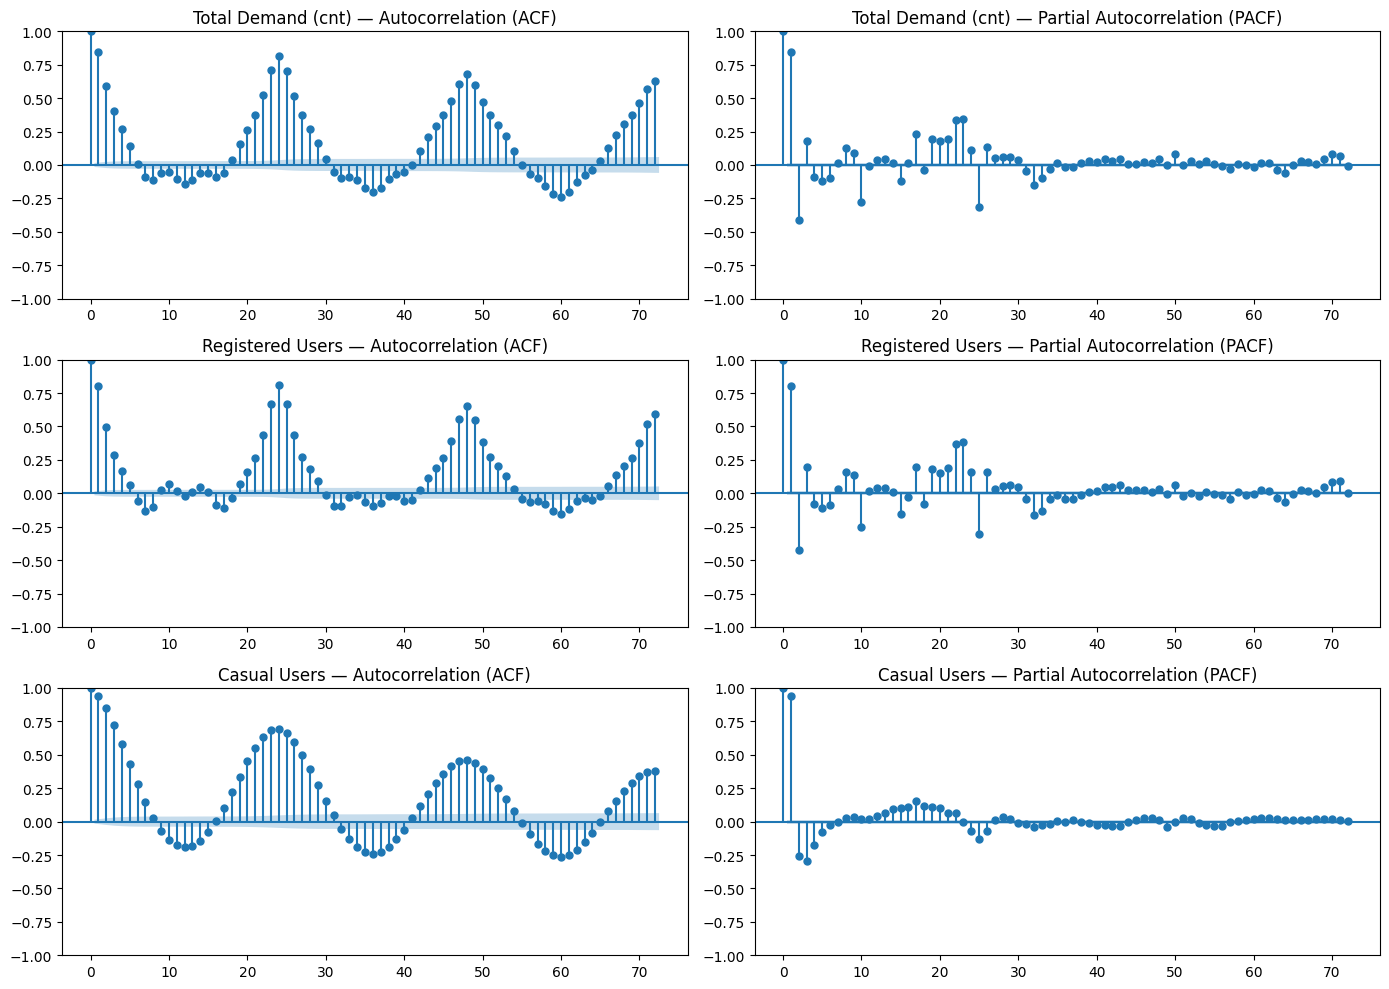

In [31]:
# --- Prepare datetime index (for hourly data) ---
df['datetime'] = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
df = df.set_index('datetime')

# --- Plot settings ---
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
targets = ['cnt', 'registered', 'casual']
titles = ['Total Demand (cnt)', 'Registered Users', 'Casual Users']

# --- Loop through each target ---
for i, col in enumerate(targets):
    y = df[col]
    plot_acf(y, lags=72, ax=axes[i,0])
    plot_pacf(y, lags=72, ax=axes[i,1])
    axes[i,0].set_title(f"{titles[i]} — Autocorrelation (ACF)")
    axes[i,1].set_title(f"{titles[i]} — Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()
fig.savefig( "Autocorrelation_Plots.png", dpi=300, bbox_inches='tight')

**Observations from Plots**

| Variable                     | ACF pattern                                                                           | PACF pattern                                            | Interpretation                                                                                             |
| ---------------------------- | ------------------------------------------------------------------------------------- | ------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **`cnt` (Total Demand)**     | Strong positive correlation at lags **1–3**, **24**, and **48**                       | Sharp cutoff after lag 3; secondary peaks around lag 24 | Hourly persistence and strong **daily periodicity**.                                                       |
| **`registered` (Commuters)** | Similar pattern to `cnt` — spikes at **1–3**, **24**, **48**                          | PACF significant up to lag ~3                           | Highly structured **daily cycle** (commute behavior) — repeat every 24h.                                   |
| **`casual` (Tourists)**      | Smooth sinusoidal pattern → decaying correlation through lags, peaks around 24 and 48 | PACF spikes mostly at lag **1**, maybe **2**            | More **seasonal and continuous** effect; weaker day-to-day repetition, more influenced by weather/leisure. |


In [32]:
lags_cnt = [1, 2, 3, 24, 48]
lags_registered = [1, 2, 3, 24, 48]
lags_casual = [1, 2, 24]

for lag in lags_casual:
    df[f'casual_lag{lag}'] = df['casual'].shift(lag)

for lag in lags_registered:
    df[f'registered_lag{lag}'] = df['registered'].shift(lag)

for lag in lags_cnt:
    df[f'cnt_lag{lag}'] = df['cnt'].shift(lag)

df = df.dropna(subset=[c for c in df.columns if "lag" in c])


## PART III: Preprocessing and Feature Engineering

### 3.1 Data Overview Before Feature Engineering

Before creating new features, we examine the dataset structure and confirm that all relevant variables (predictors and targets) are correctly formatted. This helps ensure that the next transformations will behave as expected.

In [33]:
print("======================\n df.head()")
display(df.head())
print("======================\n ")
df[['hr','casual','registered','cnt']].head()

 df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered_lag1,registered_lag2,registered_lag3,registered_lag24,registered_lag48,cnt_lag1,cnt_lag2,cnt_lag3,cnt_lag24,cnt_lag48
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-03 01:00:00,49,2011-01-03,1,0,1,1,0,1,1,1,...,5.0,8.0,9.0,13.0,13.0,5.0,8.0,9.0,17.0,16.0
2011-01-03 04:00:00,50,2011-01-03,1,0,1,4,0,1,1,1,...,2.0,5.0,8.0,16.0,32.0,2.0,5.0,8.0,17.0,40.0
2011-01-03 05:00:00,51,2011-01-03,1,0,1,5,0,1,1,1,...,1.0,2.0,5.0,8.0,27.0,1.0,2.0,5.0,9.0,32.0
2011-01-03 06:00:00,52,2011-01-03,1,0,1,6,0,1,1,1,...,3.0,1.0,2.0,4.0,10.0,3.0,1.0,2.0,6.0,13.0
2011-01-03 07:00:00,53,2011-01-03,1,0,1,7,0,1,1,1,...,30.0,3.0,1.0,1.0,1.0,30.0,3.0,1.0,3.0,1.0


,hr,casual,registered,cnt
datetime,,,,
2011-01-03 01:00:00,1,0,2,2
2011-01-03 04:00:00,4,0,1,1
2011-01-03 05:00:00,5,0,3,3
2011-01-03 06:00:00,6,0,30,30
2011-01-03 07:00:00,7,1,63,64


In [34]:
### 3.2 Target Definition and Feature Separation

We separate our target variables — one for each user type — and define the input features (X) for modeling. This ensures flexibility when training separate models for casual and registered users.

In [35]:
y_registered = df['registered']
y_casual = df['casual']
y_cnt = df["cnt"]
x = df.drop(target + ["instant"],axis= 1)
x.head()


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,registered_lag1,registered_lag2,registered_lag3,registered_lag24,registered_lag48,cnt_lag1,cnt_lag2,cnt_lag3,cnt_lag24,cnt_lag48
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-03 01:00:00,2011-01-03,1,0,1,1,0,1,1,1,0.20,...,5.0,8.0,9.0,13.0,13.0,5.0,8.0,9.0,17.0,16.0
2011-01-03 04:00:00,2011-01-03,1,0,1,4,0,1,1,1,0.16,...,2.0,5.0,8.0,16.0,32.0,2.0,5.0,8.0,17.0,40.0
2011-01-03 05:00:00,2011-01-03,1,0,1,5,0,1,1,1,0.16,...,1.0,2.0,5.0,8.0,27.0,1.0,2.0,5.0,9.0,32.0
2011-01-03 06:00:00,2011-01-03,1,0,1,6,0,1,1,1,0.14,...,3.0,1.0,2.0,4.0,10.0,3.0,1.0,2.0,6.0,13.0
2011-01-03 07:00:00,2011-01-03,1,0,1,7,0,1,1,1,0.14,...,30.0,3.0,1.0,1.0,1.0,30.0,3.0,1.0,3.0,1.0


We now have a clear separation between predictors and targets, preparing the dataset for tailored feature creation per user type.

### 3.3 Adding Nonlinear and Interaction Features

To streamline the workflow and keep the notebook organized, all feature engineering logic is stored in a separate Python script.
This script defines custom transformations that enrich the dataset with nonlinear, cyclic, and interaction-based features — allowing the model to better capture real behavioral patterns.

In [36]:
import sys
from pathlib import Path

# Assuming PROJECT_ROOT is now correctly defined (e.g., via the Path.cwd().parent logic)
# You can use the explicit path for safety if needed, but using Path objects is best practice.
PROJECT_ROOT = Path(r"C:\Users\Radwan\Downloads\IE University\Term_2\PYTHON FOR DATA ANALYSIS II\Group Assignment\bike-sharing")

# Insert the project root into the system path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT.name} to sys.path.")
    
# Re-define paths dependent on PROJECT_ROOT
ARTS_PATH = PROJECT_ROOT / "artifacts"
ARTS_PATH.mkdir(exist_ok=True, parents=True)
print(f"Artifacts Path: {ARTS_PATH}")

✅ Added bike-sharing to sys.path.
Artifacts Path: C:\Users\Radwan\Downloads\IE University\Term_2\PYTHON FOR DATA ANALYSIS II\Group Assignment\bike-sharing\artifacts


In [37]:
# This line should now work without error
from src.feature_functions import add_features 
print("✅ 'add_features' imported successfully from src.feature_functions.")

✅ 'add_features' imported successfully from src.feature_functions.


Adding Features

In [38]:
x = add_features(x)

In [39]:
# x.drop(["dteday"],axis= 1,inplace= True)
x.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,doy,daylight_hours,hr_sin,hr_cos,mnth_sin,mnth_cos,weekday_sin,weekday_cos,season_sin,season_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-03 01:00:00,2011-01-03,1,0,1,1,0,1,1,1,0.20,...,3,9.356433,0.258819,9.659258e-01,0.5,0.866025,0.781831,0.62349,1.0,6.123234e-17
2011-01-03 04:00:00,2011-01-03,1,0,1,4,0,1,1,1,0.16,...,3,9.356433,0.866025,5.000000e-01,0.5,0.866025,0.781831,0.62349,1.0,6.123234e-17
2011-01-03 05:00:00,2011-01-03,1,0,1,5,0,1,1,1,0.16,...,3,9.356433,0.965926,2.588190e-01,0.5,0.866025,0.781831,0.62349,1.0,6.123234e-17
2011-01-03 06:00:00,2011-01-03,1,0,1,6,0,1,1,1,0.14,...,3,9.356433,1.000000,6.123234e-17,0.5,0.866025,0.781831,0.62349,1.0,6.123234e-17
2011-01-03 07:00:00,2011-01-03,1,0,1,7,0,1,1,1,0.14,...,3,9.356433,0.965926,-2.588190e-01,0.5,0.866025,0.781831,0.62349,1.0,6.123234e-17


These engineered functions extend model flexibility, allowing it to better approximate nonlinear effects that linear models would otherwise miss.

### 3.4 Feature Correlation Analysis (Registered Users)

We examine how each engineered feature relates to the number of registered users. This analysis helps identify which transformations — such as hourly or workday interactions — have the strongest relationship with user activity.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


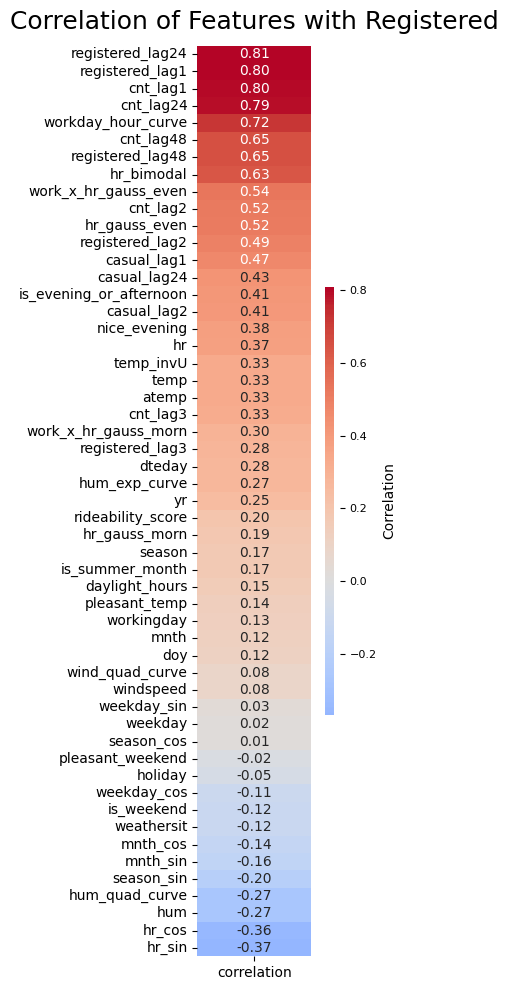

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation Calculation ---
correlation_with_casual = (
    x.corrwith(y_registered)
    .to_frame(name='correlation')
    .sort_values(by='correlation', ascending=False)
)

# --- Define a Matplotlib layout helper ---
def set_fig_layout(title=None):
    plt.title(title or "", fontsize=18, pad=12, loc="center")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# --- Plot ---
plt.figure(figsize=(4, 10))
ax = sns.heatmap(
    correlation_with_casual,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_kws={"label": "Correlation"},
    yticklabels=correlation_with_casual.index
)

# --- Colorbar adjustments ---
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_aspect(40)

# --- Apply your custom layout style ---
set_fig_layout("Correlation of Features with Registered")

# --- Save Figure ---
plt.savefig("Correlation_of_Features_with_Registered.png", dpi=300, bbox_inches="tight")


The strongest correlations appear for workday_hour_curve (0.72) and hr_bimodal (0.63), showing that time-of-day and workday cycles are key predictors of registered users. Hour-related variables outperform weather-based ones, confirming that registered users have more routine, predictable behavior (commuting patterns).

### 3.5 Feature Correlation Analysis (Casual Users)

We now analyze which features correlate the most with casual users.
Since casual riders depend more on weather and leisure conditions, we expect temperature, daylight, and weekend variables to be more relevant.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


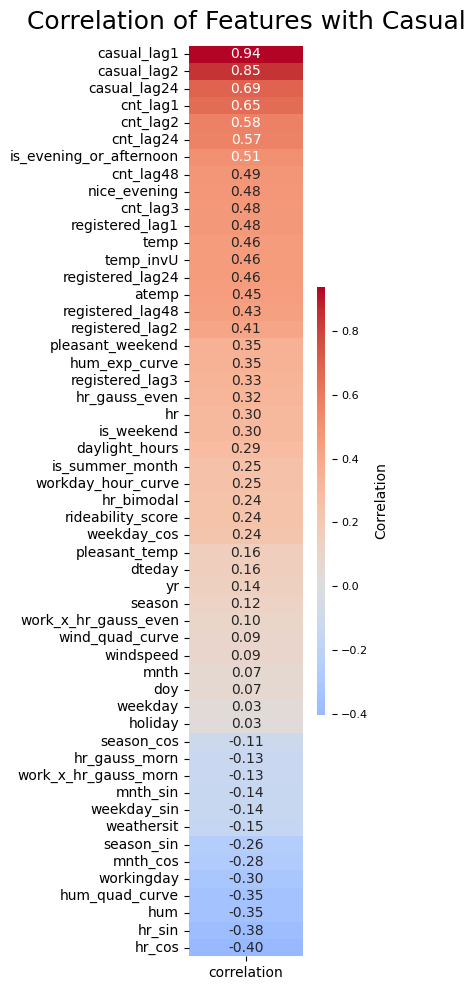

✅ Saved as Correlation_of_Features_with_Casual.png


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation Calculation ---
correlation_with_casual = (
    x.corrwith(y_casual)
    .to_frame(name='correlation')
    .sort_values(by='correlation', ascending=False)
)

# --- Define a figure layout helper ---
def set_fig_layout(title=None):
    plt.title(title or "", fontsize=18, pad=12, loc="center")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# --- Plot ---
fig, ax = plt.subplots(figsize=(4, 10))
sns.heatmap(
    correlation_with_casual,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_kws={"label": "Correlation"},
    yticklabels=correlation_with_casual.index,
    ax=ax
)

# --- Colorbar adjustments ---
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_aspect(40)

# --- Apply your layout settings ---
set_fig_layout("Correlation of Features with Casual")

# --- Save the figure ---
fig.savefig("Correlation_of_Features_with_Casual.png", dpi=300, bbox_inches="tight")
print("✅ Saved as Correlation_of_Features_with_Casual.png")


Top features include is_evening_or_afternoon (0.51) and nice_evening (0.48), confirming that casual usage peaks during warm, pleasant afternoons.
Weather and temperature variables have stronger correlations here than for registered users, reinforcing that casual demand is more seasonal and weather-dependent.

### 3.6 Feature Correlation Analysis (Total Demand — cnt)

Finally, we evaluate correlations against total demand (cnt). Since total demand combines both registered and casual users, this correlation summary captures overall drivers of system-wide activity.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


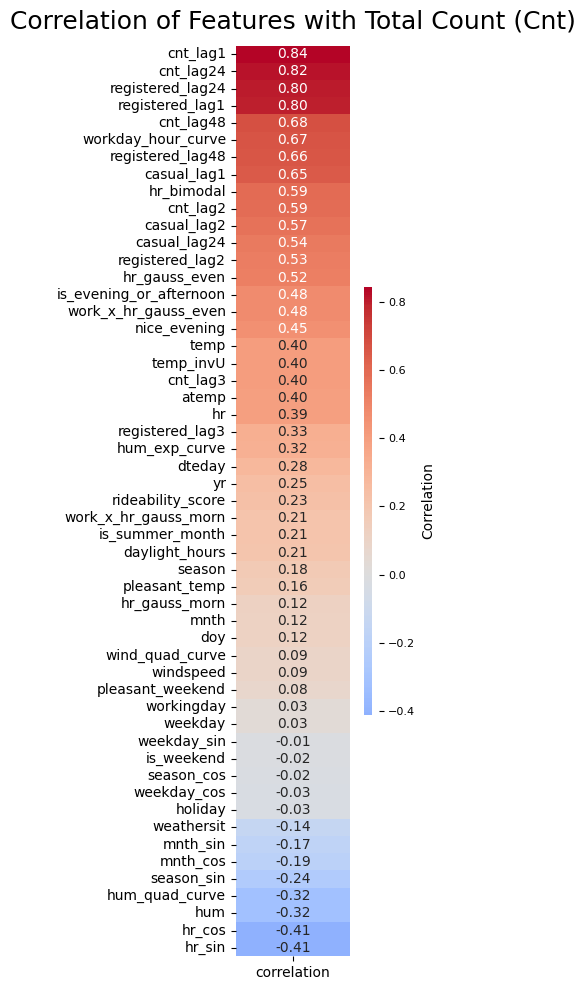

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation Calculation ---
correlation_with_cnt = (
    x.corrwith(y_cnt)
    .to_frame(name='correlation')
    .sort_values(by='correlation', ascending=False)
)

# --- Define a reusable layout helper ---
def set_fig_layout(title=None):
    plt.title(title or "", fontsize=18, pad=12, loc="center")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# --- Plot ---
fig, ax = plt.subplots(figsize=(4, 10))
sns.heatmap(
    correlation_with_cnt,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True,
    cbar_kws={"label": "Correlation"},
    yticklabels=correlation_with_cnt.index,
    ax=ax
)

# --- Colorbar adjustments ---
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_aspect(40)

# --- Apply consistent styling ---
set_fig_layout("Correlation of Features with Total Count (Cnt)")

# --- Save Figure ---
fig.savefig("Correlation_of_Features_with_Total_Count_Cnt.png", dpi=300, bbox_inches="tight")

In [43]:
## PART IV: Prediction Model

In [44]:
### 4.1 Train-Test Split for Time Series Modeling

To prepare the data for time-series forecasting, we use TimeSeriesSplit to create sequential train/test splits. This ensures that the model always trains on past data and predicts on unseen future data, preserving temporal order.

In [45]:
from sklearn.model_selection import TimeSeriesSplit

# One splitter for both
tscv = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)

for train_idx, test_idx in tscv.split(x):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train_registered, y_test_registered = y_registered.iloc[train_idx], y_registered.iloc[test_idx]
    y_train_casual, y_test_casual = y_casual.iloc[train_idx], y_casual.iloc[test_idx]

print(x_train.shape)
print(x_test.shape)
print(y_train_casual.shape)
print(y_test_casual.shape)
print(y_train_registered.shape)
print(y_test_registered.shape)

(16584, 53)
(720, 53)
(16584,)
(720,)
(16584,)
(720,)


* Adding a 24-hour gap prevents information leakage between train and test windows.

* Each fold simulates a realistic forecasting scenario, where the model is tested on future-like data.

### 4.2 Building Preprocessing Pipelines

We build a modular preprocessing pipeline that standardizes numerical features, encodes categorical ones, and applies custom feature transformations.
This pipeline will later be used both for model training and for deployment through the dashboard.

In [46]:
import skopt
print(skopt.__version__)

0.10.2


In [47]:
x_train.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual_lag1', 'casual_lag2', 'casual_lag24', 'registered_lag1',
       'registered_lag2', 'registered_lag3', 'registered_lag24',
       'registered_lag48', 'cnt_lag1', 'cnt_lag2', 'cnt_lag3', 'cnt_lag24',
       'cnt_lag48', 'temp_invU', 'hum_quad_curve', 'hum_exp_curve',
       'wind_quad_curve', 'hr_bimodal', 'hr_gauss_morn', 'hr_gauss_even',
       'workday_hour_curve', 'work_x_hr_gauss_morn', 'work_x_hr_gauss_even',
       'is_weekend', 'is_evening_or_afternoon', 'is_summer_month',
       'pleasant_temp', 'rideability_score', 'pleasant_weekend',
       'nice_evening', 'doy', 'daylight_hours', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'season_sin', 'season_cos'],
      dtype='object')

In [48]:
# we are building the preprocessor to be able to make predicttion through the Dashboard

import pandas as pd
import joblib
from pathlib import Path

# --- Assuming X_train is your feature DataFrame used for model training ---

# 1. Define the list of all lagged features
# (Note: This list may need adjustment based on your full feature set)
LAG_FEATURES = [
    'casual_lag1', 'casual_lag2', 'casual_lag24',
    'registered_lag1', 'registered_lag2', 'registered_lag3',
    'registered_lag24', 'registered_lag48',
    'cnt_lag1', 'cnt_lag2', 'cnt_lag3', 'cnt_lag24', 'cnt_lag48'
]

lag_means_dict = x_train[LAG_FEATURES].mean().to_dict()



joblib.dump(lag_means_dict,  "lag_means.pkl")

print(f"✅ Lag averages saved to { 'lag_means.pkl'}")

numerical_features_to_scale = [
    'casual_lag1', 'casual_lag2', 'casual_lag24',
    'registered_lag1', 'registered_lag2', 'registered_lag3',
    'registered_lag24', 'registered_lag48',
    'cnt_lag1', 'cnt_lag2', 'cnt_lag3', 'cnt_lag24', 'cnt_lag48',
    'temp_invU', 'hum_quad_curve', 'hum_exp_curve', 'wind_quad_curve',
    'hr_bimodal', 'hr_gauss_morn', 'hr_gauss_even', 'workday_hour_curve',
    'work_x_hr_gauss_morn', 'work_x_hr_gauss_even',
    'pleasant_temp', 'rideability_score',
     'daylight_hours'
]

categorical_features = ['weathersit']


ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False, dtype=int)

fe_add_features = FunctionTransformer(add_features, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features),
        ("scaling",StandardScaler(), numerical_features_to_scale),
    ],
    remainder="passthrough", 
)

processing_pipeline = Pipeline(steps= 
                                [("add_features",fe_add_features),
                                ("preproessor", preprocessor)] )
processing_pipeline.fit_transform(x_train)
joblib.dump(processing_pipeline,  "preprocessor.pkl")


✅ Lag averages saved to lag_means.pkl


['preprocessor.pkl']

The preprocessing pipeline ensures consistency between training and production. It can be reused later in a dashboard or automated retraining workflow.

In [49]:
x_train = x_train.drop(columns=['dteday']).copy()
x_test  = x_test.drop(columns=['dteday']).copy()

In [50]:
### 4.3 Bayesian Hyperparameter Tuning — Random Forest (Casual Users)

To optimize our Random Forest model efficiently, we use Bayesian optimization instead of traditional grid search. Bayesian Search CV intelligently explores the hyperparameter space by learning from previous evaluations, finding the best model configuration with fewer iterations. This method is particularly useful for time-series data, where each fold is computationally expensive.

In [51]:

from sklearn.ensemble import RandomForestRegressor
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical  # Real if you need continuous ranges

full_pipeline = Pipeline(steps=[
    ("preprocessor", processing_pipeline), 
    ("model", RandomForestRegressor(random_state=42))
])
space = {
    "model__n_estimators": Integer(890, 900),
    "model__max_depth": Categorical([10,15,30]),
    "model__min_samples_split": Integer(2, 10),
    "model__min_samples_leaf":  Integer(1, 10),
    "model__max_features": Categorical(["sqrt"]),
    "model__bootstrap": Categorical([True]),
}

bayes_search = BayesSearchCV(
    estimator=full_pipeline,
    search_spaces=space,
    n_iter=25,               # number of Bayesian trials
    cv=tscv,                 # your TimeSeriesSplit
    n_jobs=-1,
    random_state=42,
    verbose=0,
    refit=True               # keep best_estimator_
)

bayes_search.fit(x_train, y_train_casual)
best_model = bayes_search.best_estimator_

# --- Evaluate on train/validation/test ---
# Validation score already inside grid_search.best_score_
train_score = best_model.score(x_train, y_train_casual)
val_score   = bayes_search.best_score_
test_score  = best_model.score(x_test, y_test_casual)

print("\n--- Model Performance [Casual] ---")
print(f"Train R²:        {train_score:.4f}")
print(f"Validation R²:   {val_score:.4f}")
print(f"Test R²:         {test_score:.4f}")

# --- Detailed metrics (MAE, RMSE, R²) on test set ---
y_pred_train = best_model.predict(x_train)
y_pred_test  = best_model.predict(x_test)


# ---- Save casual model ----
casual_model_path = "model_casual.pkl"
joblib.dump(best_model, casual_model_path)  # assumes last fitted model is casual
print(f"✅ Casual model saved as {casual_model_path}")

casual_meta = {
    "model": "RandomForestRegressor",
    "target": "casual",
    "trained_on": str(datetime.date.today()),
    "train_R2": float(train_score),
    "val_R2": float(val_score),
    "test_R2": float(test_score)
}

json.dump(casual_meta, open("model_casual_meta.json", "w"), indent=2)

metrics = pd.DataFrame({
    "Set": ["Train", "Test"],
    "R2": [r2_score(y_train_casual, y_pred_train),
           r2_score(y_test_casual, y_pred_test)],
    "MAE": [mean_absolute_error(y_train_casual, y_pred_train),
            mean_absolute_error(y_test_casual, y_pred_test)],
    "RMSE": [np.sqrt(mean_squared_error(y_train_casual, y_pred_train)),
             np.sqrt(mean_squared_error(y_test_casual, y_pred_test))]
})
print("\n--- Detailed Metrics ---")
display(metrics)



--- Model Performance [Casual] ---
Train R²:        0.9876
Validation R²:   0.9231
Test R²:         0.8631
✅ Casual model saved as model_casual.pkl

--- Detailed Metrics ---


,Set,R2,MAE,RMSE
0,Train,0.987641,3.592717,5.56358
1,Test,0.863074,5.286906,8.33605


### 4.5 Random Forest Model for Registered Users

Train a robust, non-parametric model for the registered target using a pipeline and time-series cross-validation. A grid search over key hyperparameters selects the best model while preserving temporal order to avoid leakage.

In [52]:
from sklearn.ensemble import RandomForestRegressor

full_pipeline = Pipeline(
    steps=[("preprocessor", processing_pipeline), # we are using linear regrission to combine both models, so that is why we are scaling
           ("model", RandomForestRegressor(random_state=42))]
)

# Parameters: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt',
#  'model__max_samples': 1.0, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500}

param_grid = {
    "model__n_estimators": [300,500,700],          # number of trees
    "model__max_depth": [5,10,20],             # control model complexity
    "model__min_samples_split": [2],          # min samples to split an internal node
    "model__min_samples_leaf": [ 10,20],            # min samples required at a leaf node
    "model__max_features": ["sqrt",],    # feature sampling per split
    "model__bootstrap": [True],               # bootstrap sampling for bagging (RF only)
}

grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=tscv,           
    n_jobs=-1,       # Use all available CPU cores
    verbose=1        
)

grid_search.fit(x_train, y_train_registered)
# --- Extract best model from grid search ---
best_model = grid_search.best_estimator_

# Quantify generalization by reporting R² on train, cross-validated folds, and the hold-out test set. Add MAE and RMSE for error magnitude.
train_score = best_model.score(x_train, y_train_registered)
val_score   = grid_search.best_score_
test_score  = best_model.score(x_test, y_test_registered)

print("\n--- Model Performance[Registered] ---")
print(f"Train R²:        {train_score:.4f}")
print(f"Validation R²:   {val_score:.4f}")
print(f"Test R²:         {test_score:.4f}")

# --- Detailed metrics (MAE, RMSE, R²) on test set ---
y_pred_train = best_model.predict(x_train)
y_pred_test  = best_model.predict(x_test)

metrics = pd.DataFrame({
    "Set": ["Train", "Test"],
    "R2": [r2_score(y_train_registered, y_pred_train),
           r2_score(y_test_registered, y_pred_test)],
    "MAE": [mean_absolute_error(y_train_registered, y_pred_train),
            mean_absolute_error(y_test_registered, y_pred_test)],
    "RMSE": [np.sqrt(mean_squared_error(y_train_registered, y_pred_train)),
             np.sqrt(mean_squared_error(y_test_registered, y_pred_test))]
})
print("\n--- Detailed Metrics ---")
display(metrics)



# ---- Save registered model ----
registered_model_path = "model_registered.pkl"
joblib.dump(best_model, registered_model_path)  # if running the registered block last
print(f"✅ Registered model saved as {registered_model_path}")

registered_meta = {
    "model": "RandomForestRegressor",
    "target": "registered",
    "trained_on": str(datetime.date.today()),
    "train_R2": float(train_score),
    "val_R2": float(val_score),
    "test_R2": float(test_score)
}
json.dump(registered_meta, open("model_registered_meta.json", "w"), indent=2)



Fitting 5 folds for each of 18 candidates, totalling 90 fits

--- Model Performance[Registered] ---
Train R²:        0.9716
Validation R²:   0.9286
Test R²:         0.9518

--- Detailed Metrics ---


,Set,R2,MAE,RMSE
0,Train,0.971620,15.252245,25.504108
1,Test,0.951818,21.364458,33.502562


✅ Registered model saved as model_registered.pkl


In [53]:
### 4.8 Load Trained Models and Generate Predictions

Load the previously trained models for casual and registered segments and produce aligned predictions on the same feature frame.

In [54]:


# --- 1️⃣ Load both models ---
casual_model = joblib.load("model_casual.pkl")
registered_model = joblib.load("model_registered.pkl")

# --- 2️⃣ Use the same feature DataFrame for prediction ---
# Make and x_test_registered contain the same columns and order
# (they should if you built them from the same cleaned dataset)

y_pred_casual = casual_model.predict(x_test)
y_pred_registered = registered_model.predict(x_test)

# --- 3️⃣ Combine predictions ---
y_pred_cnt = y_pred_casual + y_pred_registered

# --- 4️⃣ Evaluate combined predictions against the real total (cnt) ---
# cnt = registered + casual
y_test_cnt = y_test_casual + y_test_registered

r2 = r2_score(y_test_cnt, y_pred_cnt)
mae = mean_absolute_error(y_test_cnt, y_pred_cnt)
rmse = np.sqrt(mean_squared_error(y_test_cnt, y_pred_cnt))

print("\n--- Combined Predictions (Casual + Registered = CNT) ---")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



--- Combined Predictions (Casual + Registered = CNT) ---
R²: 0.9538
MAE: 22.58
RMSE: 35.33


Keeping both models separate supports clear error analysis by segment while enabling a simple and interpretable aggregation step.

In [55]:
### 4.10 Visual Diagnostics: Actual vs Predicted (Casual / Registered / CNT)

Inspect temporal fit and residual structure with synchronized subplots for each series, focusing on a recent window for clarity.

In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Helper function for consistent styling ---
def set_fig_layout(fig, show=True):
    fig.update_layout(
        template='plotly_white',
        title_x=0.5,
        font=dict(family='Times New Roman', size=16),
        title_font=dict(size=24),
        legend_title_text='User Type'
    )
    if show:
        fig.show()

# --- Time axis ---
t = y_test_casual.index

# --- Number of hours to plot ---
n = 720

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles=("Casual Users", "Registered Users", "Total Demand (CNT)")
)

# --- 1. Casual Users ---
fig.add_scatter(x=t[:n], y=y_test_casual.values[:n], mode="lines",
                name="Actual Casual", row=1, col=1)
fig.add_scatter(x=t[:n], y=y_pred_casual[:n], mode="lines",
                name="Predicted Casual", row=1, col=1)

# --- 2. Registered Users ---
fig.add_scatter(x=t[:n], y=y_test_registered.values[:n], mode="lines",
                name="Actual Registered", row=2, col=1)
fig.add_scatter(x=t[:n], y=y_pred_registered[:n], mode="lines",
                name="Predicted Registered", row=2, col=1)

# --- 3. Total Demand (CNT) ---
fig.add_scatter(x=t[:n], y=y_test_cnt.values[:n], mode="lines",
                name="Actual CNT", row=3, col=1)
fig.add_scatter(x=t[:n], y=y_pred_cnt[:n], mode="lines",
                name="Predicted CNT", row=3, col=1)

# --- Layout & axes setup ---
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    height=800,
    title="Actual vs Predicted — Casual / Registered / CNT",
    margin=dict(t=80, b=60, l=60, r=30)
)

fig.update_xaxes(title_text="Time", row=3, col=1)
fig.update_yaxes(title_text="Casual", row=1, col=1)
fig.update_yaxes(title_text="Registered", row=2, col=1)
fig.update_yaxes(title_text="CNT", row=3, col=1)

# --- Apply your style ---
set_fig_layout(fig, show=True)

# --- Save interactive HTML ---
fig.write_html("Actual_vs_Predicted_Casual_Registered_CNT.html")

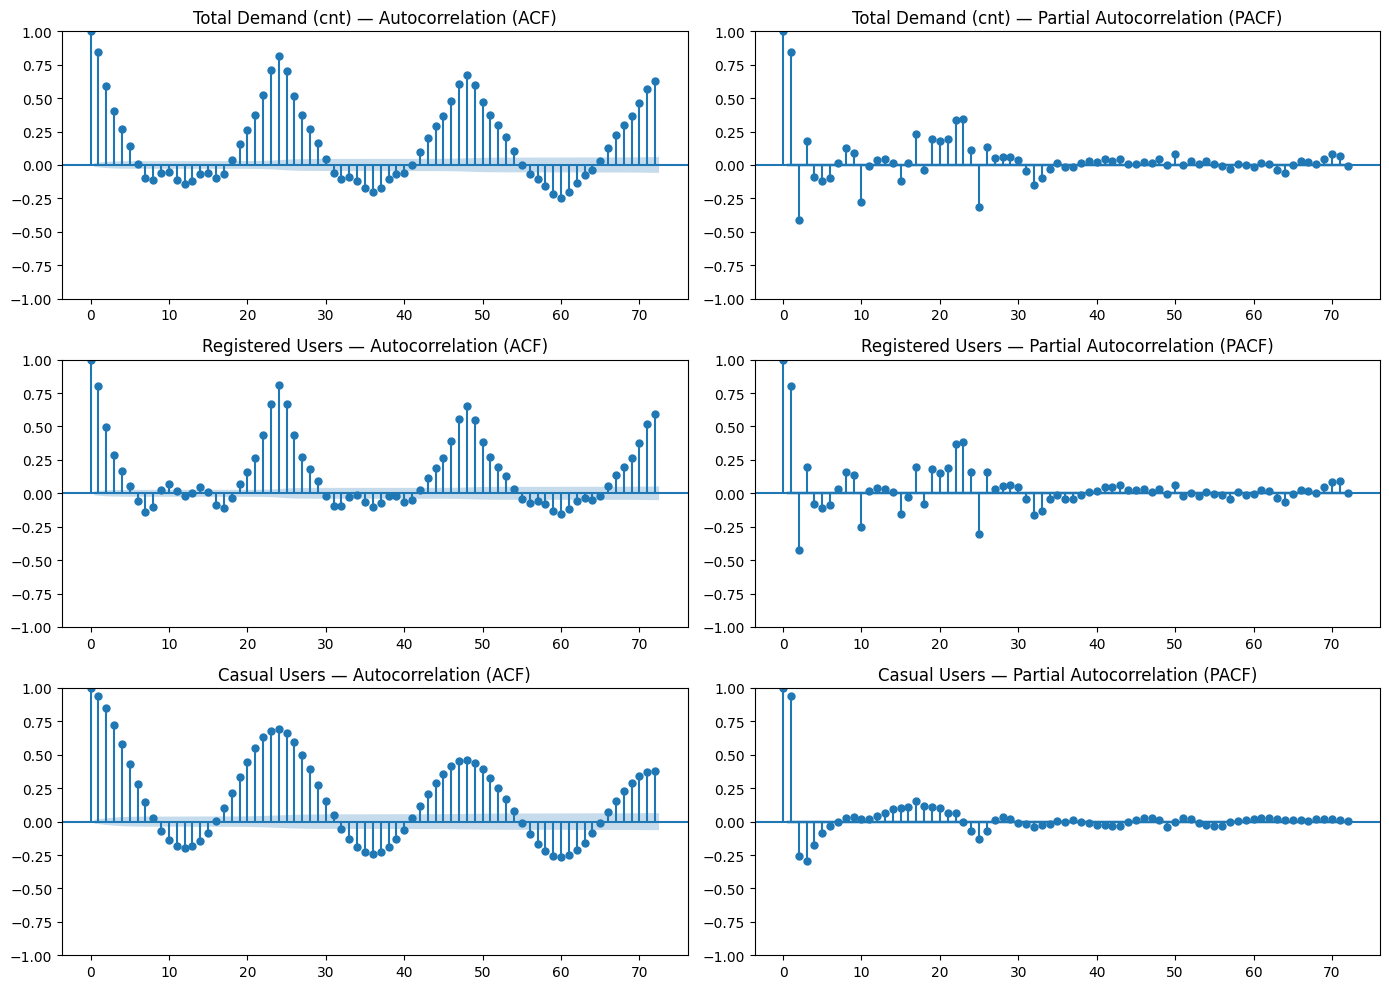

In [57]:


# --- Prepare datetime index (for hourly data) ---
df['datetime'] = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
df = df.set_index('datetime')

# --- Plot settings ---
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
targets = ['cnt', 'registered', 'casual']
titles = ['Total Demand (cnt)', 'Registered Users', 'Casual Users']

# --- Loop through each target ---
for i, col in enumerate(targets):
    y = df[col]
    plot_acf(y, lags=72, ax=axes[i,0])
    plot_pacf(y, lags=72, ax=axes[i,1])
    axes[i,0].set_title(f"{titles[i]} — Autocorrelation (ACF)")
    axes[i,1].set_title(f"{titles[i]} — Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()
fig.savefig( "Autocorrelation_Plots.png", dpi=300, bbox_inches='tight')

